In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize  import curve_fit
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from scipy.stats import norm,t
import scipy as sp
from scipy import interpolate
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# from adjustText import adjust_text
from ast import literal_eval
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from matplotlib_venn import venn3, venn3_circles

from scipy.stats import kde
import seaborn as sns
from scipy.stats import fisher_exact
from scipy.interpolate import Rbf
from scipy import stats
from scipy.stats import norm,t

In [56]:
# NOTE: using data and code from https://www.nature.com/articles/s41467-024-49920-8/figures/6

# git hub: https://github.com/wuhrlab/ProteinTurnoverEcoli (Reproduce Figure 3 and 6.ipynb)

In [5]:
# load in the data:
sheets = pd.read_excel('Clim_data.xlsx')
sheets

,Protein ID,Gene names,C-lim3_1,C-lim3_2,C-lim3_mean,C-lim6_1,C-lim6_2,C-lim6_mean,C-lim12_1,C-lim12_2,C-lim12_mean
0,sp|A5A614|YCIZ_ECOLI,yciZ,NaN,NaN,NaN,3.932642,3.601144,3.766893,NaN,NaN,NaN
1,sp|O32583|THIS_ECOLI,thiS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.469682,4.469682
2,sp|P00350|6PGD_ECOLI,gnd,3.248315,3.163151,3.205733,5.572427,6.131487,5.851957,10.201045,9.866244,10.033644
3,sp|P00363|FRDA_ECOLI,frdA,2.992966,2.946457,2.969711,6.080384,6.670409,6.375396,13.518765,10.761427,12.140096
4,sp|P00370|DHE4_ECOLI,gdhA,3.076857,2.810401,2.943629,4.462108,4.855534,4.658821,7.653326,6.91881,7.286068
...,...,...,...,...,...,...,...,...,...,...,...
2948,sp|Q46892|YGBN_ECOLI,ygbN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.22677,15.226770
2949,sp|Q46943|YQEJ_ECOLI,yqeJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000*,16.000000
2950,sp|Q47274|REQ1_ECOLI,quuD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733813,8.733813
2951,sp|Q47534|YAIO_ECOLI,yaiO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.379927,15.379927


In [46]:
def convert_to_nan(df, rep_column_name):
    # Print nans prior to clean up:
    print("The original number of NaNs in column ",rep_column_name," are: ",df[rep_column_name].isna().sum())
    # Convert any half-lives that are not numbers to NaN:
    df[rep_column_name] = pd.to_numeric(df[rep_column_name], errors='coerce')

    # Print nans after clean up:
    nan_count = df[rep_column_name].isna().sum()
    print("Number of NaN values after clean up and converting to integers:", nan_count)
    return df

In [7]:
# For Figure 6 
Dilution_half_life_hrs= 12
clim12_1= sheets[['Protein ID', 'Gene names ', 'C-lim12_1']].rename(columns={'C-lim12_1': 'rep1'},)
clim12_2= sheets[['Protein ID', 'Gene names ', 'C-lim12_2']].rename(columns={'C-lim12_2': 'rep2'})

Dilution_half_life_hrs= 3
clim3_1= sheets[['Protein ID', 'Gene names ', 'C-lim3_1']].rename(columns={'C-lim3_1': 'rep1'},)
clim3_2= sheets[['Protein ID', 'Gene names ', 'C-lim3_2']].rename(columns={'C-lim3_2': 'rep2'},)

Dilution_half_life_hrs= (6)
clim6_1= sheets[['Protein ID', 'Gene names ', 'C-lim6_1']].rename(columns={'C-lim6_1': 'rep1'},)
clim6_2= sheets[['Protein ID', 'Gene names ', 'C-lim6_2']].rename(columns={'C-lim6_2': 'rep2'},)

sheets

,Protein ID,Gene names,C-lim3_1,C-lim3_2,C-lim3_mean,C-lim6_1,C-lim6_2,C-lim6_mean,C-lim12_1,C-lim12_2,C-lim12_mean
0,sp|A5A614|YCIZ_ECOLI,yciZ,NaN,NaN,NaN,3.932642,3.601144,3.766893,NaN,NaN,NaN
1,sp|O32583|THIS_ECOLI,thiS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.469682,4.469682
2,sp|P00350|6PGD_ECOLI,gnd,3.248315,3.163151,3.205733,5.572427,6.131487,5.851957,10.201045,9.866244,10.033644
3,sp|P00363|FRDA_ECOLI,frdA,2.992966,2.946457,2.969711,6.080384,6.670409,6.375396,13.518765,10.761427,12.140096
4,sp|P00370|DHE4_ECOLI,gdhA,3.076857,2.810401,2.943629,4.462108,4.855534,4.658821,7.653326,6.91881,7.286068
...,...,...,...,...,...,...,...,...,...,...,...
2948,sp|Q46892|YGBN_ECOLI,ygbN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.22677,15.226770
2949,sp|Q46943|YQEJ_ECOLI,yqeJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000*,16.000000
2950,sp|Q47274|REQ1_ECOLI,quuD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.733813,8.733813
2951,sp|Q47534|YAIO_ECOLI,yaiO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.379927,15.379927


In [48]:
# NOTE: I removed several columns from the dataset. 

filevar_names = ['clim6_1','clim6_2','clim12_1', 'clim12_2' , 'clim3_1', 'clim3_2']

for filevar_name in filevar_names:
    
    print("-------Evaluating: ",filevar_name,"----------------")
    if filevar_name.split('_')[0] == 'expgrowth':
        element = (42.45/60)
        element2 = filevar_name.split('_')[1]
        rep_column_name = 'rep'+element2
        tolerance= 2- (42.45/60)
    else:
        element = int(filevar_name.split('lim')[1].split('_')[0])
        element2 = filevar_name.split('_')[1]
        rep_column_name = 'rep'+element2
        hi = 6
        if element ==6: 
            tolerance= 2
        elif element ==3: 
            tolerance= 1
        else:
            tolerance=4
        print (element, rep_column_name)
        
    df_original = eval(filevar_name)
    df_cleaned = convert_to_nan(df_original, rep_column_name)
 
    if element == 6:
        print("The number of negatives in filename ",filevar_name,"are: ",(df_cleaned[rep_column_name]<0).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]<0),'rep'+element2] = element

        print("The number of values in filename ",filevar_name,"with half lives greater than ",str(element),"+", str(tolerance), "are: ",(eval(filevar_name)['rep'+element2]-tolerance>element).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]-tolerance>element),'rep'+element2] = element+tolerance
        
    elif ((element == 12)):
        print("The number of negatives in filename ",filevar_name,"are: ",(df_cleaned[rep_column_name]<0).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]<0),'rep'+element2] = element

        print("The number of values in filename ",filevar_name,"with half lives greater than ",str(element),"+", str(tolerance), "are: ",(eval(filevar_name)['rep'+element2]-tolerance>element).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]-tolerance>element),'rep'+element2] = element+tolerance
    
    elif ((element==3)):
        print("The number of negatives in filename ",filevar_name,"are: ",(df_cleaned[rep_column_name]<0).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]<0),'rep'+element2] = element

        print("The number of values in filename ",filevar_name,"with half lives greater than ",str(element),"+", str(tolerance), "are: ",(eval(filevar_name)['rep'+element2]-tolerance>element).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]-tolerance>element),'rep'+element2] = element+tolerance
    
    else:
        print("The number of negatives in filename ",filevar_name,"are: ",(df_cleaned[rep_column_name]<0).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]<0),'rep'+element2] = element

        print("The number of values in filename ",filevar_name,"with half lives greater than ",str(element),"+", str(tolerance), "are: ",(eval(filevar_name)['rep'+element2]-tolerance>element).sum())
        eval(filevar_name).loc[(eval(filevar_name)['rep'+element2]-tolerance>element),'rep'+element2] = element+tolerance
    print("-------Completed: ",filevar_name,"----------------")
    print("\n")



-------Evaluating:  clim6_1 ----------------
6 rep1
The original number of NaNs in column  rep1  are:  477
Number of NaN values after clean up and converting to integers: 477
The number of negatives in filename  clim6_1 are:  0
The number of values in filename  clim6_1 with half lives greater than  6 + 2 are:  0
-------Completed:  clim6_1 ----------------


-------Evaluating:  clim6_2 ----------------
6 rep2
The original number of NaNs in column  rep2  are:  650
Number of NaN values after clean up and converting to integers: 650
The number of negatives in filename  clim6_2 are:  0
The number of values in filename  clim6_2 with half lives greater than  6 + 2 are:  0
-------Completed:  clim6_2 ----------------


-------Evaluating:  clim12_1 ----------------
12 rep1
The original number of NaNs in column  rep1  are:  651
Number of NaN values after clean up and converting to integers: 651
The number of negatives in filename  clim12_1 are:  0
The number of values in filename  clim12_1 with h

In [80]:
def header_splitter(x):
#     print("hi")
#     print(x)
    if(x.count('|')==2):
         y=x.split('|')[1]  # takes only number as an identifier
    elif (x.count('|')==1):
         y=x.split('|')[0] 
    else:
         y=x
    return y
def sub_cellular(choice, df): 
    if choice =='o': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==True) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    elif choice =='p': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Periplasm')==True]
    elif choice=='c': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('Cytoplasm')==True]
    elif choice=='m': 
        df_return= df[df['Subcellular location [CC] 1'].str.contains('membrane')==True]
    elif choice=='i': 
        df_return = df[(df['Subcellular location [CC] 1'].str.contains('outer')==False) & (df['Subcellular location [CC] 1'].str.contains('membrane')==True) ]
    return (df_return)

def active_degrading_func(df, filename1,cutoff_pvalue): 
    df['Entry']= df['Protein ID'].apply(header_splitter)
    #df= df.merge(tmt5_location[['Entry', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
        
    relevant_degrading = df[df['average_hl_%s'%(filename1.split (' ')[0])]<=Dilution_half_life_hrs]
    relevant_degrading2 = relevant_degrading [relevant_degrading ['pvalues_hl_%s_new'%(filename1.split (' ')[0])]<=cutoff_pvalue]
    
    return (relevant_degrading2, float(len(relevant_degrading2))/ len(df))

### Conservative error estimates from the replicates
def shared_variance(df,average_hl_colname,filename):
    if Dilution_half_life_hrs==6: 
        bins = [0,2,5,8]
    elif Dilution_half_life_hrs==12: 
        bins= [0,2, 4, 8, 10, 16]
    elif Dilution_half_life_hrs==3: 
        bins= [0,1, 2, 3, 7]
    else: 
        bins= [0,0.5, 2]
    
    # Step1: Divide half_lives into bins
        
    df.loc[:,'average_hl_bin'] = pd.cut(df[average_hl_colname],bins)

    # Step2: Calculate the median sandard error of each bin
    
    df = df.merge(pd.DataFrame(df[~df['average_hl_bin'].isnull()].groupby('average_hl_bin')['hl_std_error'].quantile(0.5).reset_index(drop=False).rename({'hl_std_error':'hl_std_error_50percentile'},axis=1)),how='left')
   
    # Step 3: Make all the proteins in a bin have the median std error 
    # or its original value if that is greater than the median 
    
    df.loc[:,'hl_std_error_new'] = df['hl_std_error']
    df.loc[df['hl_std_error']<=df['hl_std_error_50percentile'],'hl_std_error_new'] = df['hl_std_error_50percentile']
    df.loc[df['hl_std_error'].isnull(),'hl_std_error_new'] = df['hl_std_error_50percentile']
    
    df['hl_zscore_new']=(df[average_hl_colname]- Dilution_half_life_hrs)/ df['hl_std_error_new']
    df['pvalues_hl_%s_new'%(filename.split (' ')[0])]= df['hl_zscore_new'].map(lambda x:(1 - t.cdf(abs(x), 1)))

    return (df.drop(columns=['average_hl_bin']))


def merge_replicates (a, b, filename1): 
    
    if Dilution_half_life_hrs==12: 
        limit_value=16
    elif Dilution_half_life_hrs==6 : 
        limit_value=8 
    elif Dilution_half_life_hrs==3: 
        limit_value= 5
    else: limit_value=2
 
    merged= a[['Protein ID', 'Gene names ','rep1']].merge(b[['Protein ID', 'rep2']], on='Protein ID', how='inner').dropna()
   
    print ('The number of proteins in each data set merged %d'%(merged.shape[0]))

    merged['Entry']= merged['Protein ID'].apply(header_splitter)
    
    #merged= merged.merge(tmt5_location[['Entry', 'Gene names ', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
    
    merged['rep1_cap']= merged['rep1'].map(lambda x: Dilution_half_life_hrs if x>Dilution_half_life_hrs else x)
    merged['rep2_cap']= merged['rep2'].map (lambda x: Dilution_half_life_hrs if x>Dilution_half_life_hrs else x )
    
   ########################### Calculate p values based on replicates #################################################

    rep_columns=['Protein ID', 'Gene names ']+ [col for col in merged.columns if 'rep' in col]
    merged1= merged.loc[:,rep_columns]
    merged1.loc[:,'average_hl_%s'%(filename1.split (' ')[0])]= (merged1[['rep1','rep2']].mean(axis=1))
    
    merged1.loc[:,'hl_std_dev']= merged1[['rep1', 'rep2']].std(axis=1)
    merged1.loc[:,'hl_std_error']= merged1[['rep1', 'rep2']].std(axis=1)/ np.sqrt(2)
    merged1.loc[:,'hl_zscore']=(merged1['average_hl_%s'%(filename1.split (' ')[0])]- Dilution_half_life_hrs)/ merged1['hl_std_error']
    merged1.loc[:,'pvalues_hl_%s'%(filename1.split (' ')[0])]= merged1['hl_zscore'].map(lambda x:(1 - t.cdf(abs(x), 1)) * 2)
    return_df = (merged1.loc[:,['Protein ID','Gene names ','hl_std_error','average_hl_%s'%(filename1.split (' ')[0]), 'pvalues_hl_%s'%(filename1.split (' ')[0])]])
    
    merged2=shared_variance(return_df.copy(),average_hl_colname = 'average_hl_%s'%(filename1.split (' ')[0]),filename=filename1)

    merged2['Entry']= merged2['Protein ID'].apply(header_splitter)
    #merged2= merged2.merge(tmt5_location[['Entry', 'Gene names ', 'Subcellular location [CC] 1', 'membrane_confirmation']], on='Entry', how='left')
    merged2.loc[:,'average_hl_%s_cap'%(filename1.split (' ')[0])]= merged2.loc[:,'average_hl_%s'%(filename1.split (' ')[0])].map (lambda x: Dilution_half_life_hrs if x>Dilution_half_life_hrs else x )
    merged2= merged2.rename(columns={'hl_std_error_new': 'hl_std_error_new_%s'%(filename1.split (' ')[0]), 'hl_std_error': 'hl_std_error_%s'%(filename1.split (' ')[0])})
    
    
    degrading, fraction_degrading= active_degrading_func(merged2.copy(),filename1, 0.05)
    degrading['Degrading']='yes'
    merged2= merged2.merge(degrading[['Protein ID', 'Degrading']], on='Protein ID', how='left')
    print ('Fraction of the proteome degrading %f'%(fraction_degrading))
    return (merged2)

In [79]:
Dilution_half_life_hrs=6
filename= 'C limited 6'
clim6_merged_inner= merge_replicates(clim6_1,clim6_2, filename1= filename)

Dilution_half_life_hrs=12
filename= 'C limited 12'
clim12_merged_inner= merge_replicates(clim12_1,clim12_2,  filename1= filename)

Dilution_half_life_hrs=3
filename= 'C limited 3'
clim3_merged_inner= merge_replicates(clim3_1,clim3_2, filename1= filename)

The number of proteins in each data set merged 2153
Fraction of the proteome degrading 0.174640
The number of proteins in each data set merged 2131
Fraction of the proteome degrading 0.237916
The number of proteins in each data set merged 2115
Fraction of the proteome degrading 0.115366


In [78]:
# Files used for the scaling comparison
clim3_merged_inner1= clim3_merged_inner[['Protein ID', 'average_hl_C', 'hl_std_error_new_C', 'Degrading']].rename(columns= {'average_hl_C':'average_hl_C3', 'hl_std_error_new_C': 'hl3_std_error_new', 'Degrading':'Degrading_3'})
clim3_merged_inner1

clim6_merged_inner1= clim6_merged_inner[['Protein ID', 'average_hl_C', 'hl_std_error_new_C', 'Degrading']].rename(columns= {'average_hl_C':'average_hl_C6', 'hl_std_error_new_C': 'hl6_std_error_new', 'Degrading':'Degrading_6'})
clim6_merged_inner1

clim12_merged_inner1= clim12_merged_inner[['Protein ID', 'average_hl_C', 'hl_std_error_new_C', 'Degrading']].rename(columns= {'average_hl_C':'average_hl_C12', 'hl_std_error_new_C': 'hl12_std_error_new', 'Degrading':'Degrading_12'})
clim12_merged_inner1


,Protein ID,average_hl_C12,hl12_std_error_new,Degrading_12
0,sp|P00350|6PGD_ECOLI,10.033644,0.637451,NaN
1,sp|P00363|FRDA_ECOLI,12.140096,1.378669,NaN
2,sp|P00370|DHE4_ECOLI,7.286068,0.388147,yes
3,sp|P00393|DHNA_ECOLI,11.781129,0.637451,NaN
4,sp|P00448|SODM_ECOLI,11.260014,1.187632,NaN
...,...,...,...,...
2126,sp|Q47142|HCAT_ECOLI,10.437209,0.637451,NaN
2127,sp|P0AFM4|PSIF_ECOLI,6.857473,1.019065,NaN
2128,sp|P30131|HYPF_ECOLI,9.744548,1.711155,NaN
2129,sp|P75734|CHIQ_ECOLI,9.675921,1.823390,NaN


In [81]:
def function_scaling_plot (xaxis1, d1, d2, scaled): 
    if scaled==False: 
          yaxis_plot= 1/(1/xaxis1-1/d1+1/d2)
    else: yaxis_plot= d2/d1*xaxis1
    return yaxis_plot

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_66202/3640232020.py:3: RuntimeWarning: divide by zero encountered in divide
  yaxis_plot= 1/(1/xaxis1-1/d1+1/d2)


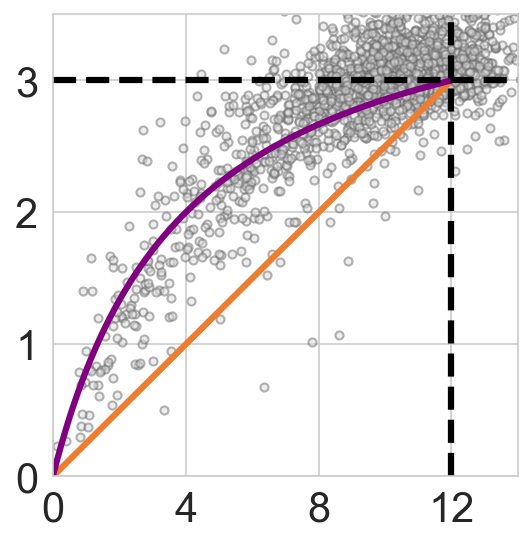

In [83]:
c_scaling3_12= clim3_merged_inner1.merge(clim12_merged_inner1, on='Protein ID', how='inner')
c_scaling3_12['Entry']= c_scaling3_12['Protein ID'].apply(header_splitter)
#c_scaling3_12= c_scaling3_12.merge(tmt5_location, on='Entry', how='left')

# Cap the half lives 
c_scaling3_12['average_hl_C3_cap']= c_scaling3_12['average_hl_C3'].map(lambda x: 3 if x> 3 else x)
c_scaling3_12['average_hl_C12_cap']= c_scaling3_12['average_hl_C12'].map(lambda x: 12 if x> 12 else x)

# Throw out proteins that are very noisy based on standard error of two replicates
c_scaling3_121= c_scaling3_12[(c_scaling3_12['average_hl_C3_cap']<5)& (c_scaling3_12['hl12_std_error_new']<3.6)]
# plt.hist(c_scaling3_121['hl12_std_error_new'], alpha=0.5)
# plt.hist(c_scaling3_121['hl3_std_error_new'], alpha=0.5)
# plt.xlabel('Standard_error_new')
# plt.show()

fig=plt.figure(figsize=(4,4), dpi=150)
ax = fig.add_subplot(111)

ax.scatter(c_scaling3_121['average_hl_C12'], c_scaling3_121['average_hl_C3'], s=15, alpha=0.5, color='gainsboro', edgecolors='dimgray')

xaxis_plot= np.linspace(0,12,10000)

plt.plot(xaxis_plot,function_scaling_plot(xaxis_plot,12,3, scaled=True), ls='-', lw=3, color='#ed7d31', label='Scaled')

plt.plot(xaxis_plot,function_scaling_plot(xaxis_plot,12,3, scaled=False), ls='-', lw=3, color='purple', label='Not scaled')


ax.set_yticks(np.arange(0,5, 1))
ax.set_xticks(np.arange(0,16,4))

ax.set(ylim=(0, 3.5), xlim=(0,14))


plt.axhline(3, color='black', ls='--', lw=3)
plt.axvline(12, color='black', ls='--', lw=3)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()



